In [ ]:
% matplotlib inline
import bidict
import os
import csv
import scipy.sparse
import numpy as np
import random
import matplotlib.pyplot as plt
import load_data
from blessings import Terminal
term = Terminal()
print term.blue('kotek')

In [32]:
# constants
all_compounds_file = 'Random_compounds_100.sdf'
folder_with_pairs = 'pairs'
n_sets = 10

possible_compounds = 'possible compounds'
pairs_contained = 'pairs contained'
probability = 'probability'
compounds_contained = 'compounds contained'
size = 'size'

In [ ]:
def clustering_score(clusters, n_omitted):
    # chcemy niską wariancję i mało pominiętych par
    assert isinstance(clusters, list), 'clusters should be a non-empty list of dictionaries'
    assert len(clusters) > 0, 'clusters should be a non-empty list of dictionaries'
    assert isinstance(clusters[0], dict), 'clusters should be a non-empty list of dictionaries'
    variance = 0
    if pairs_contained in clusters[0].keys():
        variance = np.var([float(len(cluster[pairs_contained]))/(cluster[probability][1]-cluster[probability][0])
                       for cluster in clusters])
    elif size in clusters[0].keys():
        variance = np.var([float(cluster[size])/(cluster[probability][1]-cluster[probability][0])
                       for cluster in clusters])
    else:
        raise KeyError('either `'+size+'` or `'+pairs_contained+'` must be in clusters')
    score = (5./8)*variance + n_omitted
    return score, variance # TODO 30 - powinno byc wiecej, bo klastrow bedzie mniej

In [ ]:
def agnieszka_folds(all_compunds_file, folder_with_pairs):
    best_clusterings = []
    best_score = 10**4
    scores = []
    variances = []
    n_ommited_pairs = []
    while(True): # many times
        bin_sim, _, mapping_idx_chembl = load_data.load_similarity_matrices(all_compunds_file, folder_with_pairs)
        bin_sim.setdiag(np.zeros((bin_sim.shape[0]))) # pairs (i,i) are not interesting for us
        pairs = zip(bin_sim.nonzero()[0], bin_sim.nonzero()[1])
                
        random.shuffle(pairs)
        clusters = [{possible_compounds:list(mapping_idx_chembl.keys()), pairs_contained:[]} for i in xrange(2)]
        clusters[0][probability], clusters[1][probability] = (0.0, 0.9), (0.9, 1.0)
        failures = 0
        max_failures = len(pairs)
        try:
            while failures < max_failures:
                i, j = pairs.pop() # popping random pair
                if i > j:
                    continue # saving time
                
                x = np.random.rand()
                for cluster in clusters:  # iterating over clusters to find the chosen one
                    if cluster[probability][0] <= x < cluster[probability][1]:  # if the cluster was chosen
                        # if pair might go inside
                        if i in cluster[possible_compounds] and j in cluster[possible_compounds]:
                            failures = 0
                            cluster[pairs_contained].append((i,j))
                            
                            # usun zwiazki i, j z mozliwych w kazdym klastrze poza obecnym
                            for c in clusters:
                                if i in c[possible_compounds]:
                                    c[possible_compounds].remove(i)
                                if j in c[possible_compounds]:
                                    c[possible_compounds].remove(j)
                            cluster[possible_compounds].extend([i, j])
                        else: # the cluster was chosen but we cannot fit the pair there
                            failures += 1
                            pairs.insert(0, (i, j)) # pair goes back to the poll
                        break # we've found the chosen one
                
        except IndexError:  # zbior par jest pusty
            print term.green('index error')
            pass
        finally:
            # wyszlismy z while'a, wiec albo mamy wpasowane wszystkie pary albo mielismy 100 porazek
            omitted_pairs = len(pairs)
            score, variance = clustering_score(clusters, omitted_pairs)
            
            # TODO: new score needed
            print 'score', score
            print 'omitted_pairs', omitted_pairs
            if score < best_score:
                print '\n'
                
                best_score = score
                best_clusterings.append(clusters)
                if len(best_clusterings) > n_sets:
                    best_clusterings = best_clusterings[-n_sets:]
                scores.append(best_score)
                variances.append(variance)
                n_ommited_pairs.append(omitted_pairs)
                plt.plot(range(len(scores)), scores, c='r')
                plt.plot(range(len(variances)), variances, c='g')
                plt.plot(range(len(n_ommited_pairs)), n_ommited_pairs, c='b')
                plt.title('best score over time')
                plt.show()
                print "score", score, 'variance', variance, 'omitted_pairs', omitted_pairs
                print 'wielkości klastrów', [len(cluster[pairs_contained]) for cluster in clusters]
                print 'pominietych par', omitted_pairs
                print "#BEST CLUSTERING\n", best_clusterings[-1]

    
            print '_________________________________________________\n'
    
    return best_clusterings

In [ ]:
best_clustering = agnieszka_folds(all_compounds_file, folder_with_pairs)

In [30]:
def staszek_folds(all_compounds_file, folder_with_pairs):
    best_clusterings = []
    best_score = 10**4
    scores = []
    variances = []
    n_ommited_pairs = []
    
    while(True): # many times
        bin_sim, _, mapping_idx_chembl = load_data.load_similarity_matrices(all_compunds_file, folder_with_pairs)
        bin_sim.setdiag(np.zeros((bin_sim.shape[0]))) # pairs (i,i) are not interesting for us
        pairs = zip(bin_sim.nonzero()[0], bin_sim.nonzero()[1])
                
        random.shuffle(pairs)
        clusters = [{compounds_contained:[], size:0} for i in xrange(2)]
        clusters[0][probability], clusters[1][probability] = (0.0, 0.9), (0.9, 1.0)
        
        omitted_pairs = 0
        
        for compound_index in xrange(0, len(pairs)):
            x = np.random.rand()
            for cluster in clusters:  # iterating over clusters to find the chosen one
                    if cluster[probability][0] <= x < cluster[probability][1]:  # if the cluster was chosen
                        cluster[compounds_contained].append(compound_index)
                        
        for pair in pairs:
            i, j = pair
            if i > j:
                continue # saving time
                
            contained = False
            for cluster in clusters:
                if i in cluster[compounds_contained] and j in cluster[compounds_contained]:
                    cluster[size] += 1
                    contained=True
                    break
                    
            if not contained:    
                omitted_pairs += 1

        # scoring the clustering found
        score, variance = clustering_score(clusters, omitted_pairs)
        print 'omitted_pairs', omitted_pairs
        print 'score', score
        if score < best_score:
            print '\n'

            best_score = score
            best_clusterings.append(clusters)
            if len(best_clusterings) > n_sets:
                    best_clusterings = best_clusterings[-n_sets:]
            scores.append(best_score)
            variances.append(variance)
            n_ommited_pairs.append(omitted_pairs)
            plt.plot(range(len(scores)), scores, c='r')
            plt.plot(range(len(variances)), variances, c='g')
            plt.plot(range(len(n_ommited_pairs)), n_ommited_pairs, c='b')
            plt.title('best score over time')
            plt.show()
            print "score", score, 'variance', variance, 'omitted_pairs', omitted_pairs
            print 'wielkości klastrów', [cluster[size] for cluster in clusters]
            print 'pominietych par', omitted_pairs
            print "#BEST CLUSTERING\n", best_clusterings[-1]

    
        print '_________________________________________________\n'
    
    return best_clusterings

21 pairs were omitted
omitted_pairs 57
score 26751.4444444
_________________________________________________

21 pairs were omitted
omitted_pairs 83
score 16984.2345679
_________________________________________________

21 pairs were omitted
omitted_pairs 111
score 12951.2777778
_________________________________________________

21 pairs were omitted
omitted_pairs 79
score 17440.1111111
_________________________________________________

21 pairs were omitted
omitted_pairs 92
score 13843.7361111
_________________________________________________

21 pairs were omitted
omitted_pairs 75
score 20325.0
_________________________________________________

21 pairs were omitted
omitted_pairs 103
score 5418.58641975




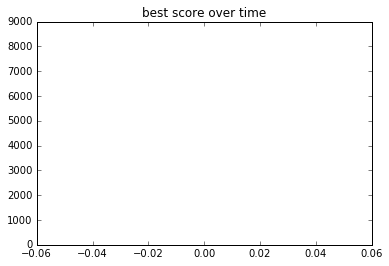

score 5418.58641975 variance 8504.9382716 omitted_pairs 103
wielkości klastrów [310, 16]
pominietych par 103
#BEST CLUSTERING
[{'compounds contained': [0, 1, 3, 5, 7, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 66, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 78, 79, 81, 82, 83, 84, 85, 86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 106, 107, 108, 109, 110, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 151, 152, 153, 154, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 171, 172, 173, 175, 176, 178, 179, 180, 181, 182, 183, 184, 185, 186, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 211, 212, 21

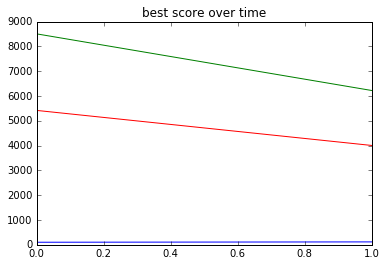

score 4006.66049383 variance 6223.45679012 omitted_pairs 117
wielkości klastrów [295, 17]
pominietych par 117
#BEST CLUSTERING
[{'compounds contained': [0, 1, 3, 4, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21, 22, 23, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 51, 52, 53, 57, 58, 60, 61, 62, 64, 65, 66, 67, 68, 69, 70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 133, 134, 135, 138, 139, 141, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 188, 189, 190, 191, 192, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213,

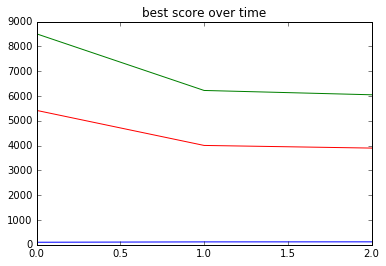

score 3899.86419753 variance 6049.38271605 omitted_pairs 119
wielkości klastrów [293, 17]
pominietych par 119
#BEST CLUSTERING
[{'compounds contained': [0, 1, 2, 4, 5, 6, 7, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 54, 55, 56, 57, 59, 60, 61, 62, 63, 64, 66, 67, 68, 70, 71, 72, 73, 74, 76, 77, 79, 80, 81, 84, 86, 87, 88, 90, 91, 94, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 108, 109, 110, 111, 112, 113, 115, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 169, 170, 171, 172, 173, 174, 175, 177, 178, 179, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 21

ValueError: I/O operation on closed file

In [31]:
best_clustering = staszek_folds(all_compounds_file, folder_with_pairs)

In [ ]:
best_clustering